## Looking for patterns in SSNA data (using Pandas)

The plan: use SSNA data exports from various projects and explore the link between semantic density of posts and topics and the structure of the conversation they are part of. 

* Semantic density is measured by the number of annotations and codes. 
* Structure comes down to the interaction network. 

### Semantic density

My first goals are:

* A frequency distribution of annotations per post (semantic density). How concentrated vs. dispersed is meaning?
* Measures of correlation between a post's semantic density and: 
    * the length of the topic the post is in;
    * the number of replies the post has;

### High level

* Read the data
* Re-organize the data to create a table as follows: 

| post_id | topic_id | annotations | author    |[quality_measures] |
|---------|----------|-------------|-----------|------------------|
| 123456  | 12345    | 5           | anon12345 | [12]             |

* compute correlation indices between columns 3 and 5. 4 can be used for correlating or regressing 3 on properties of the author, for example measures of network centrality.

**Remember**. These data are re-exported with added fields for post quality. They no longer correspond to the datasets uploaded onto Zenodo. If we do a hackathon etc, not only we should refresh the data files, but also regenerate the `datapackage.json` files.

## Part 1: data wrangling

In [1]:
import pandas as pd # the customary imports
import numpy as np

Import the files and put them into pandas dataframes

In [2]:
dirPath = '~/all_projects/'
 # path to your data folderprojects = ['ngi', 'poprebel', 'opencare'] 

participants = pd.read_csv(dirPath + projects[0] + '/participants.csv')
participants['project'] = projects[0]
annotations = pd.read_csv(dirPath + projects[0] + '/annotations.csv')
annotations['project'] = projects[0]
codes = pd.read_csv(dirPath + projects[0] + '/codes.csv')
codes['project'] = projects[0]
posts = pd.read_csv(dirPath + projects[0] + '/posts.csv')
posts['project'] = projects[0]
    
for project in projects[1:]:
    print('adding ' + project)
    participants1 = pd.read_csv(dirPath + project + '/participants.csv')
    participants1['project'] = project
    annotations1 = pd.read_csv(dirPath + project + '/annotations.csv')
    annotations1['project'] = project
    codes1 = pd.read_csv(dirPath + project + '/codes.csv')
    codes1['project'] = project
    posts1 = pd.read_csv(dirPath + project + '/posts.csv')
    posts1['project'] = project
    
    participants = participants.append(participants1, ignore_index = True)
    annotations = annotations.append(annotations1, ignore_index = True)
    codes = codes.append(codes1, ignore_index = True)
    posts = posts.append(posts1, ignore_index = True)
    
# last step: eliminate duplicates (posts assigned to more than one project and their annotations)
# except participants, who are pseudonymized anew every time, so we cannot do that

dup_ann = annotations.duplicated(subset= 'id')
dup= 0
for i in dup_ann:
    if i==True:
        dup +=1
print ('duplicated annotations: ' + str (dup))

dup_posts = posts.duplicated(subset= 'post_id')
dup= 0
for i in dup_posts:
    if i==True:
        dup +=1
print ('duplicated posts: ' + str (dup))

dup_codes = codes.duplicated(subset= 'id')
dup= 0
for i in dup_codes:
    if i==True:
        dup +=1
print ('duplicated codes: ' + str (dup))

annotations = annotations.drop_duplicates(subset='id')
codes = codes.drop_duplicates(subset='id')
posts = posts.drop_duplicates(subset= 'post_id')


adding poprebel
adding opencare
duplicated annotations: 121
duplicated posts: 21
duplicated codes: 180


Notice that the number of duplicated posts is not that high. I can keep on using the `project` variable. 

Next, add number of annotations per post. This is a `merge` operation in pandas. I don't need the `codes` dataframe for now, because the `annotations` dataframe already contains the `code_id` identifiers. Notice that in the merge I lose about 500 annotations, presumably related to posts that were dropped out of the dataset because of missing consent.

In [3]:
print(posts.shape)
print(posts.columns)
print(annotations.shape)
print(annotations.columns)

postsAnno = posts.merge(annotations, how = 'left', on='post_id')
postsAnno = postsAnno.drop(columns=['project_y', 'topic_id_y'])
print(postsAnno.shape)
print(postsAnno.columns)
print(postsAnno['id'].nunique())
print(annotations['id'].nunique())
print(postsAnno['post_id'].nunique())


(8512, 16)
Index(['post_number', 'post_id', 'created_at', 'topic_id', 'reply_count',
       'reads', 'readers_count', 'incoming_link_count', 'quote_count',
       'like_count', 'score', 'reply_to_post_id', 'source_username',
       'target_username', 'text', 'project'],
      dtype='object')
(10140, 21)
Index(['id', 'version', 'text', 'quote', 'uri', 'created_at', 'updated_at',
       'post_id', 'creator_id', 'type', 'shape', 'units', 'geometry', 'src',
       'ext', 'container', 'start', 'end', 'topic_id', 'code_id', 'project'],
      dtype='object')
(16341, 34)
Index(['post_number', 'post_id', 'created_at_x', 'topic_id_x', 'reply_count',
       'reads', 'readers_count', 'incoming_link_count', 'quote_count',
       'like_count', 'score', 'reply_to_post_id', 'source_username',
       'target_username', 'text_x', 'project_x', 'id', 'version', 'text_y',
       'quote', 'uri', 'created_at_y', 'updated_at', 'creator_id', 'type',
       'shape', 'units', 'geometry', 'src', 'ext', 'container

I use a filter mask to create a column in `postsAnno` that cointains the number of annotations. For now, I set it to `0` where the annotation `id` does not exist (is `NaN`). Elsewehere it is provisionally set to 1.

In [4]:
filt = postsAnno['id'].isna()
print(filt.describe)
postsAnno['annoexists'] = ~ filt
postsAnno['n_anns'] = postsAnno['annoexists'].astype(int)
postsAnno.drop('annoexists', axis=1, inplace=True) # delete annoexists, I no longer need it
print(postsAnno[['post_id','id', 'n_anns']].tail)

<bound method NDFrame.describe of 0         True
1         True
2         True
3         True
4         True
         ...  
16336    False
16337     True
16338     True
16339     True
16340     True
Name: id, Length: 16341, dtype: bool>
<bound method NDFrame.tail of        post_id      id  n_anns
0        55953     NaN       0
1        55962     NaN       0
2        55968     NaN       0
3        55973     NaN       0
4        55974     NaN       0
...        ...     ...     ...
16336    19954  4716.0       1
16337     8916     NaN       0
16338    12509     NaN       0
16339    15815     NaN       0
16340    18436     NaN       0

[16341 rows x 3 columns]>


Next step is to count the number of annotations for each value of `post_id`: goes in the `annotations` column. This is the number of rows of `postsAnno` that have the same value of `post_id`. This is our dependent variable.

In [5]:
mys=postsAnno.groupby('post_id').count().reset_index()
mys.rename(columns={'post_number': 'annotations'}, inplace=True)
mys =mys[['post_id', 'annotations']]
mys

,post_id,annotations
0,110,1
1,153,1
2,493,38
3,494,41
4,496,1
...,...,...
8507,80934,1
8508,80935,1
8509,80941,1
8510,80943,1


Merging the grouped dataframe with the original one adds to the latter the extra column I need, `annotations`. However, since the `count` method counts NaNs too, posts with no annotations show a count of 1, too. Fortunately, I have stored the zeros in the `n_ann` columns in `postsAnno`. 

In [6]:
postsAnno = postsAnno.merge(mys, how='left')
# since the groupby.count() method also counts NaNs, it follows that even when 'n_anns' == 0 'annotations' == 1
postsAnno.tail(10)

,post_number,post_id,created_at_x,topic_id_x,reply_count,reads,readers_count,incoming_link_count,quote_count,like_count,...,units,geometry,src,ext,container,start,end,code_id,n_anns,annotations
16331,2,6759,2012-03-13T20:50:29.000Z,1677,0,7,6,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1575.0,1,8
16332,2,6759,2012-03-13T20:50:29.000Z,1677,0,7,6,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.0,1,8
16333,3,14720,2012-03-22T14:10:03.000Z,1677,0,4,3,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1283.0,1,3
16334,3,14720,2012-03-22T14:10:03.000Z,1677,0,4,3,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,582.0,1,3
16335,3,14720,2012-03-22T14:10:03.000Z,1677,0,4,3,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1575.0,1,3
16336,4,19954,2012-05-01T10:59:09.000Z,1677,0,3,2,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.0,1,1
16337,2,8916,2012-04-23T19:44:00.000Z,1440,1,3,2,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
16338,4,12509,2012-04-23T21:22:34.000Z,1440,0,2,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
16339,6,15815,2012-04-24T11:19:26.000Z,1440,0,3,2,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
16340,8,18436,2012-04-24T12:09:28.000Z,1440,0,2,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1


I replace the zeros from `n_ann` into the `annotations` column. This yields a correct situation: the values of `annotations` now range from `0` to `105`. When `n_anns == 0`, `annotations == 0`. When `n_anns == 1`, `annotations > 0`. 

In [7]:
postsAnno.loc[postsAnno['n_anns']==0, 'annotations']= 0
print(postsAnno['annotations'].describe())
postsAnno[['n_anns', 'annotations']].tail(10)

count    16341.000000
mean         9.480876
std         17.298335
min          0.000000
25%          0.000000
50%          3.000000
75%         11.000000
max        105.000000
Name: annotations, dtype: float64


,n_anns,annotations
16331,1,8
16332,1,8
16333,1,3
16334,1,3
16335,1,3
16336,1,1
16337,0,0
16338,0,0
16339,0,0
16340,0,0


Now I can get rid of the duplicate posts. This should yield a dataframe with one row per post, i.e. `8512` rows.

In [8]:
the_table = postsAnno.drop_duplicates('post_id').drop(columns=['n_anns']).rename(columns={'topic_id_x': 'topic_id'})
the_table.tail(10)

,post_number,post_id,created_at_x,topic_id,reply_count,reads,readers_count,incoming_link_count,quote_count,like_count,...,shape,units,geometry,src,ext,container,start,end,code_id,annotations
16306,12,24619,2012-05-09T21:42:24.000Z,1485,0,3,2,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
16307,14,26260,2012-05-09T21:45:40.000Z,1485,0,2,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
16308,1,1710,2012-03-13T19:54:24.000Z,1677,1,10,9,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2859.0,17
16325,2,6759,2012-03-13T20:50:29.000Z,1677,0,7,6,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,732.0,8
16333,3,14720,2012-03-22T14:10:03.000Z,1677,0,4,3,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1283.0,3
16336,4,19954,2012-05-01T10:59:09.000Z,1677,0,3,2,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.0,1
16337,2,8916,2012-04-23T19:44:00.000Z,1440,1,3,2,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
16338,4,12509,2012-04-23T21:22:34.000Z,1440,0,2,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
16339,6,15815,2012-04-24T11:19:26.000Z,1440,0,3,2,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
16340,8,18436,2012-04-24T12:09:28.000Z,1440,0,2,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


Looks good. Now I need to compute the number of posts in each topic. I can do this from the `the_table`dataframe, as it has exactly one row per post in the original dataset.

In [9]:
myf = the_table.groupby('topic_id').count().reset_index()
myf.rename(columns={'post_number': 'posts_in_topic'}, inplace=True)
myf =myf[['topic_id', 'posts_in_topic']]
myf

,topic_id,posts_in_topic
0,77,1
1,78,1
2,120,1
3,460,8
4,461,1
...,...,...
1339,13986,9
1340,13987,3
1341,13988,60
1342,14072,2


In [10]:
the_table = the_table.merge(myf, how='left')
the_table['posts_in_topic'].describe()

count    8512.000000
mean       20.692434
std        27.375359
min         1.000000
25%         5.000000
50%        12.000000
75%        23.000000
max       142.000000
Name: posts_in_topic, dtype: float64

As a final step, I compute the length of each post from the `text_x` column.

In [11]:
the_table['char_count'] = the_table['text_x'].str.len()
the_table['char_count'].head(5)

0    12794.0
1      156.0
2      192.0
3       70.0
4       84.0
Name: char_count, dtype: float64

## Part 2. Statistical analysis

Start with histograms and simple frequency counts. The former show some kind of power-lawy behavior.

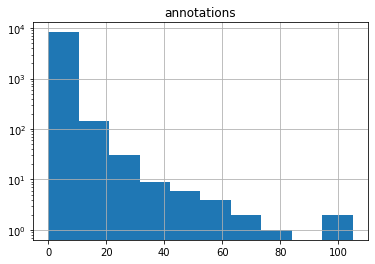

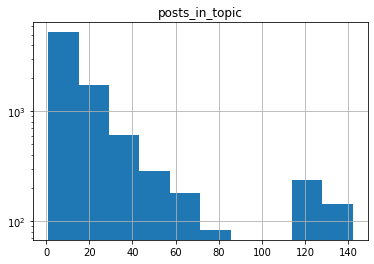

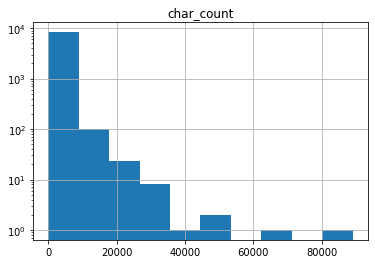

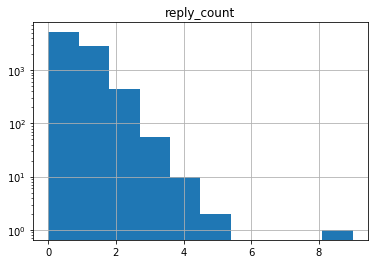

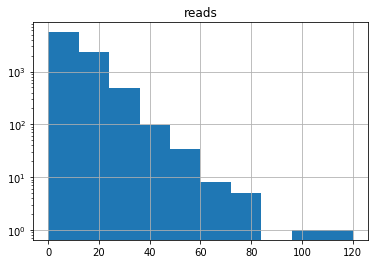

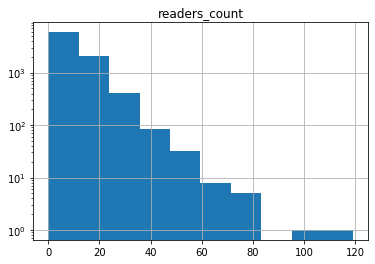

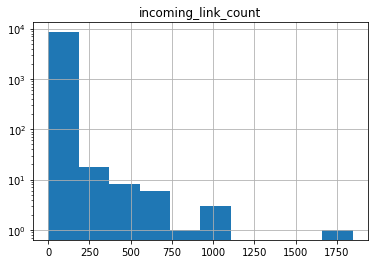

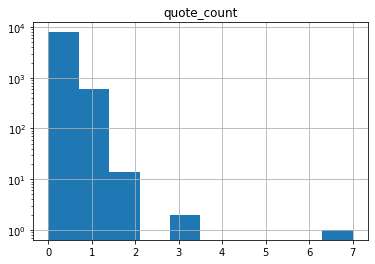

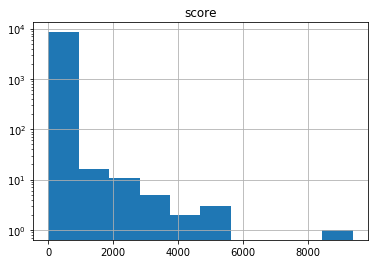

In [12]:
my_columns = ['annotations' , 'posts_in_topic', 'char_count', 'reply_count', 'reads', 'readers_count', 'incoming_link_count', 'quote_count', 'score']
for col in my_columns:
    the_table.hist(column = col, log = True)

In [13]:
for col in my_columns:
    print(the_table[col].describe())

count    8512.000000
mean        1.137570
std         4.112047
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       105.000000
Name: annotations, dtype: float64
count    8512.000000
mean       20.692434
std        27.375359
min         1.000000
25%         5.000000
50%        12.000000
75%        23.000000
max       142.000000
Name: posts_in_topic, dtype: float64
count     8472.000000
mean      1223.086992
std       2762.905139
min          3.000000
25%        179.000000
50%        483.500000
75%       1178.250000
max      89013.000000
Name: char_count, dtype: float64
count    8512.000000
mean        0.463111
std         0.647874
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         9.000000
Name: reply_count, dtype: float64
count    8512.000000
mean       10.494948
std         8.713294
min         0.000000
25%         4.000000
50%         8.000000
75%        14.000000
max       120.000000
Name: reads, d

Correlation coefficients. Counterintuitively, the correlation between the number of annotations and quality indices is quite low. Only `char_count`, `incoming_link_counts` and the composite `score` (computed by Discourse on default parameters) show correlation over 0.1. 

In [14]:
reduced = the_table[my_columns]
reduced.corr()

,annotations,posts_in_topic,char_count,reply_count,reads,readers_count,incoming_link_count,quote_count,score
annotations,1.000000,-0.063251,0.314787,0.035931,0.053185,0.053182,0.106176,-0.022958,0.114783
posts_in_topic,-0.063251,1.000000,-0.112495,0.182892,0.409954,0.409959,-0.005901,0.120444,0.013525
char_count,0.314787,-0.112495,1.000000,-0.017715,0.056545,0.056542,0.178403,-0.017490,0.191785
reply_count,0.035931,0.182892,-0.017715,1.000000,0.167755,0.167748,0.015386,0.091541,0.047727
reads,0.053185,0.409954,0.056545,0.167755,1.000000,0.999999,0.240466,0.165700,0.302308
readers_count,0.053182,0.409959,0.056542,0.167748,0.999999,1.000000,0.240468,0.165699,0.302310
incoming_link_count,0.106176,-0.005901,0.178403,0.015386,0.240466,0.240468,1.000000,-0.009352,0.991238
quote_count,-0.022958,0.120444,-0.017490,0.091541,0.165700,0.165699,-0.009352,1.000000,0.000815
score,0.114783,0.013525,0.191785,0.047727,0.302308,0.302310,0.991238,0.000815,1.000000


Try some scatterplots. They are very inconclusive. Only `char_count` offers any hope.

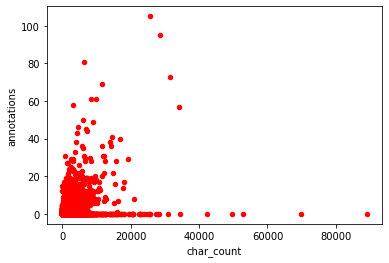

In [15]:
reduced.plot.scatter('char_count', 'annotations', c='red')


I tried eliminating the outliers with over 100 annotations and score over 9,000, but there was no significant change.

However, much of the corpus belong to unfinished projects. Let me redo this selecting only the OpenCare corpus, the only one to be fully coded.

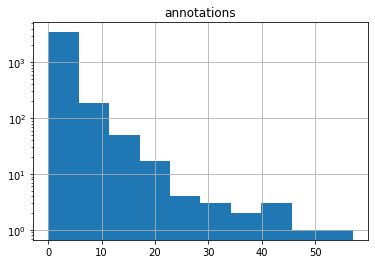

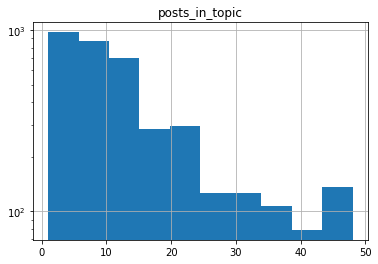

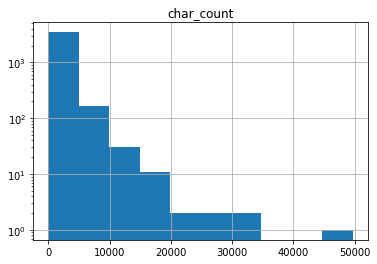

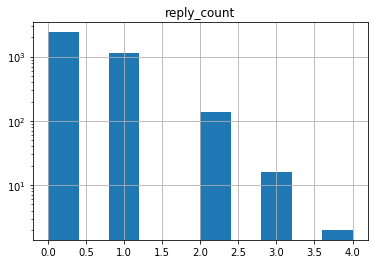

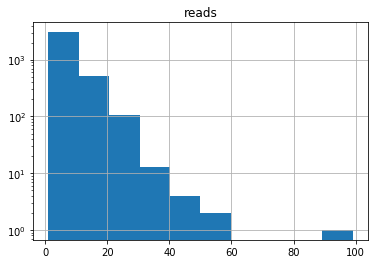

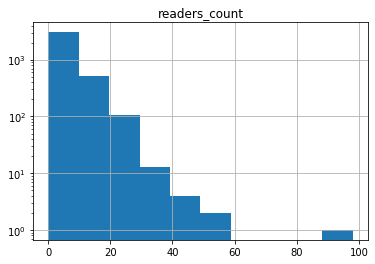

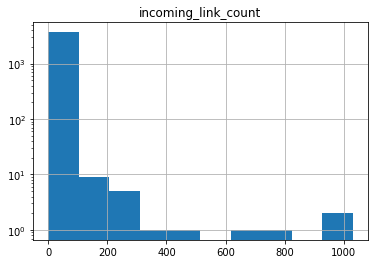

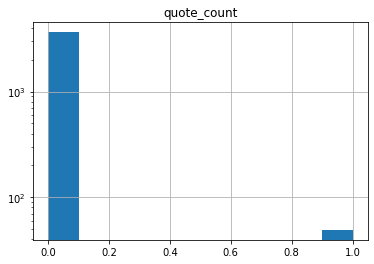

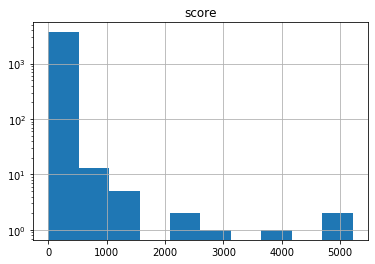

In [16]:
oc = the_table[the_table['project_x']=='opencare']
oc = oc[my_columns]
for col in my_columns:
    oc.hist(column = col, log = True)

Indeed, in this corpus the correlations are stronger.

In [17]:
oc.corr()

,annotations,posts_in_topic,char_count,reply_count,reads,readers_count,incoming_link_count,quote_count,score
annotations,1.000000,-0.062002,0.440268,-0.000274,0.074913,0.074913,0.167410,-0.021352,0.170156
posts_in_topic,-0.062002,1.000000,-0.150019,0.255381,0.048475,0.048475,-0.035349,-0.024219,-0.035126
char_count,0.440268,-0.150019,1.000000,-0.096527,0.118214,0.118214,0.177503,-0.013258,0.191591
reply_count,-0.000274,0.255381,-0.096527,1.000000,0.065870,0.065870,-0.030687,0.050470,-0.006324
reads,0.074913,0.048475,0.118214,0.065870,1.000000,1.000000,0.253248,0.102343,0.312636
readers_count,0.074913,0.048475,0.118214,0.065870,1.000000,1.000000,0.253248,0.102343,0.312636
incoming_link_count,0.167410,-0.035349,0.177503,-0.030687,0.253248,0.253248,1.000000,-0.009551,0.990915
quote_count,-0.021352,-0.024219,-0.013258,0.050470,0.102343,0.102343,-0.009551,1.000000,0.008462
score,0.170156,-0.035126,0.191591,-0.006324,0.312636,0.312636,0.990915,0.008462,1.000000


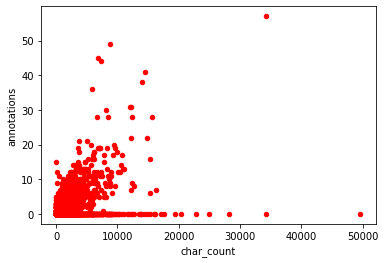

In [18]:
oc.plot.scatter('char_count', 'annotations', c='red')

Now I regress `annotations` on the other variables, or a subset thereof. For now, I do not look at regressors based on identity – or maybe I can think about introducing a dummy, let's see. 

For now I want to drop `score` (a combination of the other variables) and `readers_count` (almost equal to `reads`) on counts of multicollinearity.

Provisionally, I export the data and treat them with Stata. In the future, I hope to teach myself how to use Python statistical libraries more efficienty.

In [20]:
columns_reg = my_columns
columns_reg.append('source_username')
print(columns_reg)
ocreg = the_table[the_table['project_x']=='opencare'] # only posts with annotations from opencare 
ocreg = ocreg[columns_reg] # drop useless columns

print(ocreg.head(10))
ocreg.to_csv(dirPath + 'ocreg.csv')

['annotations', 'posts_in_topic', 'char_count', 'reply_count', 'reads', 'readers_count', 'incoming_link_count', 'quote_count', 'score', 'source_username', 'source_username']
      annotations  posts_in_topic  char_count  reply_count  reads  \
4812            0               6     15263.0            0     16   
4813            0               6       668.0            0     12   
4814            0               6      1551.0            0     11   
4815            0               6      2914.0            0      9   
4816            0               6         5.0            0      7   
4817            0               6      4556.0            0      8   
4818            5              17      3217.0            0      8   
4819            2              17       502.0            1      7   
4820            4              17      1482.0            0      5   
4821            1              17       880.0            0      5   

      readers_count  incoming_link_count  quote_count  score sourc